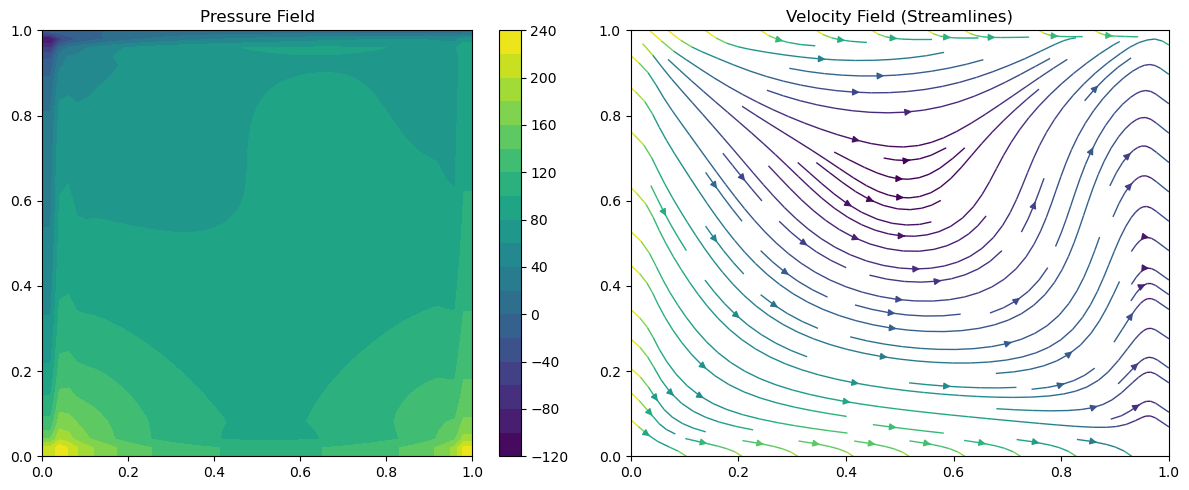

In [4]:
# ✅ Full 2D Incompressible Navier-Stokes Solver (FDM + PPE + Projection)

import numpy as np
import matplotlib.pyplot as plt

# 📏 Parameters
nx, ny = 50, 50
lx, ly = 1.0, 1.0
dx, dy = lx / (nx - 1), ly / (ny - 1)
dt = 0.001
rho = 1.0
nu = 0.1  # kinematic viscosity
nt = 500  # number of time steps

# 🧱 Mesh grid
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

# 🧩 Fields
u = np.zeros((ny, nx))  # velocity in x
v = np.zeros((ny, nx))  # velocity in y
p = np.zeros((ny, nx))  # pressure

# Temporary storage
u_star = np.zeros_like(u)
v_star = np.zeros_like(v)

# 🔧 Function: Compute RHS of PPE
def compute_rhs(u_star, v_star):
    rhs = np.zeros_like(p)
    rhs[1:-1, 1:-1] = (
        rho / dt * (
            (u_star[1:-1, 2:] - u_star[1:-1, :-2]) / (2 * dx) +
            (v_star[2:, 1:-1] - v_star[:-2, 1:-1]) / (2 * dy)
        )
    )
    return rhs

# 🔧 Function: Solve Pressure Poisson Equation (Gauss-Seidel)
def pressure_poisson(p, rhs, iterations=50):
    pn = p.copy()
    for _ in range(iterations):
        pn = p.copy()
        p[1:-1, 1:-1] = (
            (
                (pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 +
                (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2 -
                rhs[1:-1, 1:-1] * dx**2 * dy**2
            ) / (2 * (dx**2 + dy**2))
        )
        # Boundary conditions
        p[:, -1] = p[:, -2]   # dp/dx = 0
        p[:,  0] = p[:,  1]
        p[ 0, :] = p[ 1, :]   # dp/dy = 0
        p[-1, :] = 0          # p = 0 at top
    return p

# 🔁 Time loop
for n in range(nt):
    # ➤ Predictor step (u*, v*)
    u_star[1:-1, 1:-1] = (
        u[1:-1, 1:-1] + dt * (
            - u[1:-1, 1:-1] * (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx)
            - v[1:-1, 1:-1] * (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy)
            + nu * (
                (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dx**2 +
                (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dy**2
            )
        )
    )
    v_star[1:-1, 1:-1] = (
        v[1:-1, 1:-1] + dt * (
            - u[1:-1, 1:-1] * (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)
            - v[1:-1, 1:-1] * (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy)
            + nu * (
                (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, :-2]) / dx**2 +
                (v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[:-2, 1:-1]) / dy**2
            )
        )
    )

    # ➤ Pressure Poisson Equation
    rhs = compute_rhs(u_star, v_star)
    p = pressure_poisson(p, rhs)

    # ➤ Corrector step
    u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - dt / rho * (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * dx)
    v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - dt / rho * (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * dy)

    # ➤ Boundary conditions
    u[0, :] = u[-1, :] = u[:, 0] = u[:, -1] = 10
    v[0, :] = v[-1, :] = v[:, 0] = v[:, -1] = -10

# 📊 Visualization
speed = np.sqrt(u**2 + v**2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, p, 20)
plt.colorbar()
plt.title('Pressure Field')

plt.subplot(1, 2, 2)
plt.streamplot(X, Y, u, v, color=speed, linewidth=1)
plt.title('Velocity Field (Streamlines)')

plt.tight_layout()
plt.show()
